In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')

In [2]:
IMG_SIZE = 224  # FER2013 image size
EMOTION_FOLDERS = ['angry', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(EMOTION_FOLDERS)  # 7 emotion classes

In [3]:
# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

I0000 00:00:1741506271.155607 1532057 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741506271.267976 1532152 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [4]:
lock = threading.Lock()

def detect_and_crop_face(image):
    """Detects and crops the face using MediaPipe BlazeFace, then resizes to target size."""
    with lock:
        if image is None:
            print("Empty image")
            return None
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
                
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
                
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))

        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
# Define emotion labels
emotion_labels = ['0', '1', '2', '3', '4', '5', '6']
num_classes = len(emotion_labels)  # 7 classes

def image_generator(dataframe, batch_size=32):
    while True:
        batch_images = []
        batch_labels = []
        
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle at start of epoch

        for i in range(len(dataframe)):
            row = dataframe.iloc[i]
            img_path = row["path"]  
            image = cv2.imread(img_path)

            # Detect and crop the face
            face = detect_and_crop_face(image)
            if face is not None:
                batch_images.append(face)

                # Convert label from string to index
                label_str = str(row['label'])
                if label_str not in emotion_labels:
                    print(f"Warning: Unexpected label '{label_str}' found!")
                    continue  # Skip if label is not in predefined list

                label_index = emotion_labels.index(label_str)

                one_hot_label = to_categorical(label_index, num_classes=num_classes)

                batch_labels.append(one_hot_label)

            # Yield batch when full
            if len(batch_images) == batch_size:
                yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)
                batch_images = []
                batch_labels = []

        # Handle remaining samples
        if len(batch_images) > 0:
            current_size = len(batch_images)
            indices = np.random.randint(0, current_size, size=batch_size - current_size)
            for idx in indices:
                batch_images.append(batch_images[idx])
                batch_labels.append(batch_labels[idx])
            
            yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)


W0000 00:00:1741506271.328633 1532148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [6]:
# CNN Feature Extractor 1
def create_cnn_feature_extractor_1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(8, (75, 75), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (50, 50), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (25, 25), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (15, 15), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (9, 9), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_1")

# Mixture of Experts (MoE)
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor 2
def create_cnn_feature_extractor_2():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, (15, 15), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_2")

# ResNet50
def create_resnet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="ResNet50")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(224, 224, 3))
    
    cnn_model_1 = create_cnn_feature_extractor_1()
    cnn_model_2 = create_cnn_feature_extractor_2()
    resnet50_model = create_resnet_model()
    
    cnn_features_1 = cnn_model_1(inputs)
    cnn_features_2 = cnn_model_2(inputs)
    resnet50_features = resnet50_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features_2, resnet50_features])
    dense_layer = layers.Dense(512, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.5)(dense_layer)
    
    cnn_moe = create_moe(512, name="MoE_CNN_Features")(cnn_features_1)
    expression_moe = create_moe(512, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([cnn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="ExpressNet-MoE")

# Compile and Initialize Model
# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

# Define Model within Strategy Scope
with strategy.scope():
    num_classes = 7
    model = create_fer_model(num_classes)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss, 
                  metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('FER-2013-Ensemble-Vision.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reduce LR by 5% every epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=1)

model.summary()


Model: "ExpressNet-MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNNFeatureExtractor_2 (Functio  (None, 256)         458208      ['input_1[0][0]']                
 nal)                                                                                             
                                                                                                  
 ResNet50 (Functional)          (None, 2048)         23561152    ['input_1[0][0]']                
                                                                                     

In [7]:
import glob

# Get all image paths and corresponding labels
train_data = []
train_dataset_path = "FER-2013/train"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(train_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    train_data.extend([(img, label) for img in images])

val_data = []
test_dataset_path = "FER-2013/test"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(test_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    val_data.extend([(img, label) for img in images])


# Convert to Pandas DataFrame for easy access
train_df = pd.DataFrame(train_data, columns=["path", "label"])
val_df = pd.DataFrame(val_data, columns=["path", "label"])

In [8]:
train_df

,path,label
0,FER-2013/train/angry/Training_60374809.jpg,0
1,FER-2013/train/angry/Training_64262917.jpg,0
2,FER-2013/train/angry/Training_87008999.jpg,0
3,FER-2013/train/angry/Training_90778912.jpg,0
4,FER-2013/train/angry/Training_69155832.jpg,0
...,...,...
28704,FER-2013/train/surprise/Training_49077699.jpg,6
28705,FER-2013/train/surprise/Training_79588636.jpg,6
28706,FER-2013/train/surprise/Training_81312022.jpg,6
28707,FER-2013/train/surprise/Training_68787983.jpg,6


In [9]:
# Check
test_generator = image_generator(train_df, batch_size=32)
test_batch = next(test_generator)
print(f"Test batch shapes: X={test_batch[0].shape}, y={test_batch[1].shape}")

test_val_generator = image_generator(val_df, batch_size=32)
test_val_batch = next(test_val_generator)
print(f"Validation batch shapes: X={test_val_batch[0].shape}, y={test_val_batch[1].shape}")

Test batch shapes: X=(32, 224, 224, 3), y=(32, 7)
Validation batch shapes: X=(32, 224, 224, 3), y=(32, 7)


In [10]:
# Calculate steps more carefully to avoid partial batches
train_steps = len(train_df) // 32
if train_steps * 32 < len(train_df):
    train_steps += 1  # Add one step for remainder, but ensure generator yields full batches

# Train with adjusted parameters
history = model.fit(
    image_generator(train_df, batch_size=32),
    steps_per_epoch=train_steps,
    epochs=15, 
    validation_data=image_generator(val_df, batch_size=32),
    validation_steps=len(val_df) // 32,
    callbacks=[checkpoint, lr_callback, early_stopping] 
)

Epoch 1/15
898/898 [==============================] - ETA: 0s - loss: 1.4892 - accuracy: 0.5119
Epoch 1: val_accuracy improved from -inf to 0.54813, saving model to FER-2013-Ensemble-Vision.h5
898/898 [==============================] - 692s 669ms/step - loss: 1.4892 - accuracy: 0.5119 - val_loss: 1.3607 - val_accuracy: 0.5481 - lr: 9.5000e-05
Epoch 2/15
898/898 [==============================] - ETA: 0s - loss: 1.2179 - accuracy: 0.6403
Epoch 2: val_accuracy improved from 0.54813 to 0.60352, saving model to FER-2013-Ensemble-Vision.h5
898/898 [==============================] - 598s 666ms/step - loss: 1.2179 - accuracy: 0.6403 - val_loss: 1.2762 - val_accuracy: 0.6035 - lr: 9.0250e-05
Epoch 3/15
898/898 [==============================] - ETA: 0s - loss: 1.1159 - accuracy: 0.6904
Epoch 3: val_accuracy improved from 0.60352 to 0.62737, saving model to FER-2013-Ensemble-Vision.h5
898/898 [==============================] - 597s 665ms/step - loss: 1.1159 - accuracy: 0.6904 - val_loss: 1.2128

In [11]:
model.load_weights('FER-2013-Ensemble-Vision.h5')

In [12]:
# Path to test directory
TEST_DIR = "FER-2013/test"
EMOTION_FOLDERS = ['angry', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(EMOTION_FOLDERS)

def load_test_data(test_dir):
    """Loads all test images and their labels into memory."""
    images, labels = [], []

    for label, emotion in enumerate(EMOTION_FOLDERS):
        emotion_folder = os.path.join(test_dir, emotion)
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale
            if image is None:
                continue

            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to match model input size
            image = np.stack((image,)*3, axis=-1)  # Convert to 3-channel
            images.append(image / 255.0)  # Normalize pixel values
            labels.append(label)  # Store label as an integer

    return np.array(images), to_categorical(labels, num_classes=num_classes)

# Load test data
X_test, y_test = load_test_data(TEST_DIR)

print(f"Loaded {X_test.shape[0]} test images with shape {X_test.shape[1:]}")

Loaded 7178 test images with shape (224, 224, 3)


In [13]:
# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices

225/225 [==============================] - 56s 229ms/step


In [14]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=EMOTION_FOLDERS))

Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.58      0.59       958
     disgust       0.75      0.36      0.49       111
         sad       0.50      0.64      0.56      1247
       happy       0.88      0.84      0.86      1774
        fear       0.65      0.29      0.40      1024
     neutral       0.50      0.75      0.60      1233
    surprise       0.85      0.64      0.73       831

    accuracy                           0.65      7178
   macro avg       0.68      0.59      0.61      7178
weighted avg       0.68      0.65      0.64      7178



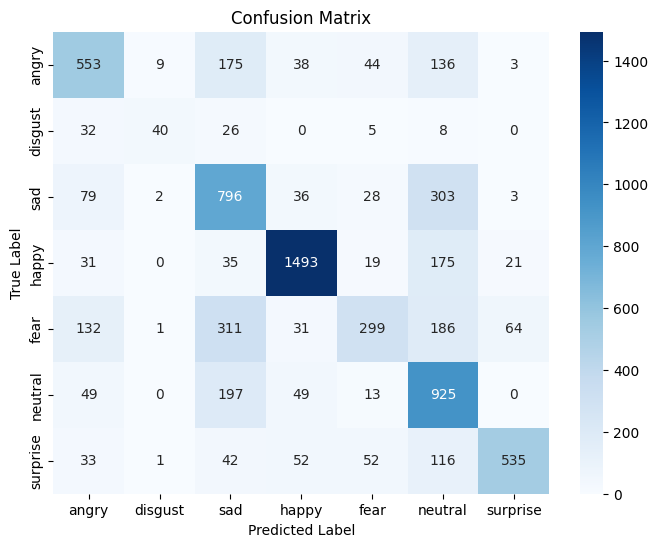

In [15]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=EMOTION_FOLDERS, yticklabels=EMOTION_FOLDERS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

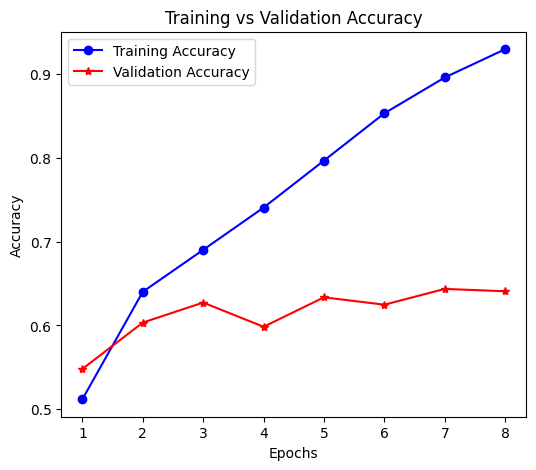

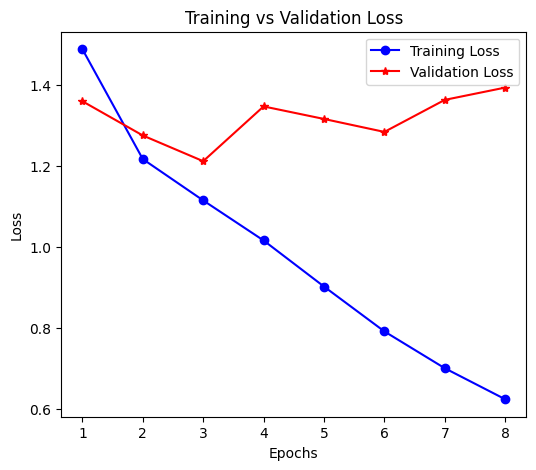

In [16]:
import matplotlib.pyplot as plt

# Define epochs based on history length
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [18]:
import json
import numpy as np

# Convert history values to Python float
history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}

# Save the converted dictionary as JSON
with open('training_history_FER-2013.json', 'w') as f:
    json.dump(history_dict, f)


In [19]:
# Evaluate the model on the entire test set
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)

print(f"Test Accuracy: {test_acc:.4f}")

225/225 [==============================] - 50s 220ms/step - loss: 1.3613 - accuracy: 0.6466
Test Accuracy: 0.6466
